<a href="https://colab.research.google.com/github/sedagulerr/ChoreMaster/blob/main/Contrastive_Learning_ile_G%C3%B6%C4%9F%C3%BCs_Kanseri_Te%C5%9Fhisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive'ı bağlama (Colab için)
from google.colab import drive
drive.mount('/content/drive')

import os
import glob

# Veri klasörlerinin yolunu tanımlama
train_dir = "/content/drive/MyDrive/breast_cancer_project/data/train"
test_dir = "/content/drive/MyDrive/breast_cancer_project/data/test"

# Her bir klasördeki görüntü sayılarını sayma
train_benign_paths = glob.glob(os.path.join(train_dir, "benign", "*.png"))
train_malig_paths = glob.glob(os.path.join(train_dir, "malignant", "*.png"))
test_benign_paths = glob.glob(os.path.join(test_dir, "benign", "*.png"))
test_malig_paths = glob.glob(os.path.join(test_dir, "malignant", "*.png"))

print(f"Eğitim - İyi huylu görüntü sayısı: {len(train_benign_paths)}")
print(f"Eğitim - Kötü huylu görüntü sayısı: {len(train_malig_paths)}")
print(f"Test - İyi huylu görüntü sayısı: {len(test_benign_paths)}")
print(f"Test - Kötü huylu görüntü sayısı: {len(test_malig_paths)}")

# Örnek bir görüntünün boyutunu kontrol etme
from PIL import Image
img = Image.open(train_benign_paths[0])
print(f"Örnek görüntü boyutu (Yükseklik x Genişlik): {img.size}")

Mounted at /content/drive
Eğitim - İyi huylu görüntü sayısı: 450
Eğitim - Kötü huylu görüntü sayısı: 350
Test - İyi huylu görüntü sayısı: 120
Test - Kötü huylu görüntü sayısı: 120
Örnek görüntü boyutu (Yükseklik x Genişlik): (700, 460)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma için ImageDataGenerator örneği olusturma
augmentation_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


def create_base_network(input_shape=(224, 224, 3)):

    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_cnn.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_cnn(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation=None)(x)
    x = layers.Dropout(0.5)(x)
    outputs = x
    model = Model(inputs, outputs, name="EmbeddingNetwork")
    return model


input_a = layers.Input(shape=(224, 224, 3), name="input_image_1")
input_b = layers.Input(shape=(224, 224, 3), name="input_image_2")

# Paylaşımlı taban ağı oluşturma
base_network = create_base_network()

# İki görüntünün gömme vektörlerini elde etme
embed_a = base_network(input_a)
embed_b = base_network(input_b)

# İki gömme arasındaki Öklidyen mesafeyi hesaplayan Lambda katmanı
def euclidean_distance(vects):
    x, y = vects
    # Öklidyen mesafe = sqrt(sum((x - y)^2))
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(sum_square)

distance = layers.Lambda(euclidean_distance, name="distance")([embed_a, embed_b])

# Siamese modeli tanımlanıyor
siamese_model = Model([input_a, input_b], distance, name="SiameseNetwork")
siamese_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingNetwork    │ (None, 256)       │ 24,112,256 │ input_image_1[0]… │
│ (Functional)        │                   │            │ input_image_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (Lambda)   │ (None, 1)         │          0 │ EmbeddingNetwork… │
│                     │                   │            │ EmbeddingNetwork… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import numpy as np

#Eğitim verisini ve doğrulama verisini ayırma
train_benign = np.array(train_benign_paths)
train_malig = np.array(train_malig_paths)
# Karıştırma
np.random.shuffle(train_benign)
np.random.shuffle(train_malig)
val_split = 0.2
val_benign_count = int(len(train_benign) * val_split)
val_malig_count = int(len(train_malig) * val_split)
val_benign = train_benign[:val_benign_count]
val_malig = train_malig[:val_malig_count]
train_benign = train_benign[val_benign_count:]
train_malig = train_malig[val_malig_count:]

print(f"Training benign: {len(train_benign)}, Training malignant: {len(train_malig)}")
print(f"Validation benign: {len(val_benign)}, Validation malignant: {len(val_malig)}")

#resim yükleyip ön işleme uygulama
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess(img_path):
    # Görüntüyü yükle ve 224x224 boyutlandırma
    img = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img)
    # Veri artırma
    img_arr = augmentation_gen.random_transform(img_arr)
    # ResNet preprocess (ImageNet normalizasyon)
    img_arr = preprocess_input(img_arr)
    return img_arr

# Contrastive loss fonksiyonunu tanımlama
import tensorflow.keras.backend as K

def contrastive_loss(y_true, y_pred):
    """ y_true: 1 -> pozitif çift (benzer), 0 -> negatif çift (farklı) """
    y_true = tf.cast(y_true, y_pred.dtype)
    # y_true = 1 için benzer: mesafenin karesi
    pos_loss = y_true * K.square(y_pred)
    # y_true = 0 için farklı: margin - mesafe pozitif ise karesini al
    margin = 1.0
    neg_loss = (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))
    return K.mean(pos_loss + neg_loss)

# Eğitim çiftlerini üretme
import math
class SiamesePairsGenerator(tf.keras.utils.Sequence):
    def __init__(self, benign_files, malign_files, batch_size=32, is_training=True):
        self.benign_files = benign_files
        self.malign_files = malign_files
        self.batch_size = batch_size
        self.is_training = is_training

        self.on_epoch_end()
    def __len__(self):

        return math.ceil(len(self.benign_files) * 2 / self.batch_size)
    def on_epoch_end(self):
        if self.is_training:
            np.random.shuffle(self.benign_files)
            np.random.shuffle(self.malign_files)
    def __getitem__(self, idx):
        # Bu fonksiyon batch_size büyüklüğünde çiftler oluşturup döndürür
        batch_x1 = []
        batch_x2 = []
        batch_y = []
        #  yarı yarıya pozitif ve negatif
        half_batch = self.batch_size // 2
        # Pozitif çiftler half_batch kadar
        for i in range(half_batch):
            # Sınıflardan rastgele seçme
            if np.random.rand() < 0.5 and len(self.benign_files) > 1:
                # Benign sınıfından bir pozitif çift
                cls_files = self.benign_files
            else:
                # Malignant sınıfından bir pozitif çift
                cls_files = self.malign_files if len(self.malign_files) > 1 else self.benign_files
            # Rastgele iki farklı örnek seçme
            a, b = np.random.choice(cls_files, size=2, replace=False)
            # Görüntüleri yükleme, işleme
            img_a = load_and_preprocess(a)
            img_b = load_and_preprocess(b)
            batch_x1.append(img_a)
            batch_x2.append(img_b)
            batch_y.append(1.0)  # aynı sınıf -> pozitif çift
        # Negatif çiftler: half_batch kadar
        for i in range(half_batch):
            # Bir benign, bir malignant seç
            if np.random.rand() < 0.5:
                # benign-> a, malignant-> b
                if len(self.benign_files) == 0 or len(self.malign_files) == 0:
                    continue
                a = np.random.choice(self.benign_files)
                b = np.random.choice(self.malign_files)
            else:
                # malignant -> a, benign -> b
                if len(self.benign_files) == 0 or len(self.malign_files) == 0:
                    continue
                a = np.random.choice(self.malign_files)
                b = np.random.choice(self.benign_files)
            img_a = load_and_preprocess(a)
            img_b = load_and_preprocess(b)
            batch_x1.append(img_a)
            batch_x2.append(img_b)
            batch_y.append(0.0)  # farklı sınıf -> negatif çift
        # Numpy array'e çevirme
        batch_x1 = np.array(batch_x1, dtype='float32')
        batch_x2 = np.array(batch_x2, dtype='float32')
        batch_y = np.array(batch_y, dtype='float32')
        return (batch_x1, batch_x2), batch_y

# Eğitim ve doğrulama jeneratörlerini oluşturma
train_gen = SiamesePairsGenerator(train_benign, train_malig, batch_size=32, is_training=True)
val_gen = SiamesePairsGenerator(val_benign, val_malig, batch_size=32, is_training=False)

# Modeli derleme
siamese_model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(0.001))
# Erken durdurma tanımlama
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Modeli eğitme
history = siamese_model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop])

Training benign: 360, Training malignant: 280
Validation benign: 90, Validation malignant: 70
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - loss: 323.9628 - val_loss: 65.0441
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - loss: 128.6210 - val_loss: 45.7991
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 92.4182 - val_loss: 38.4003
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 76.8155 - val_loss: 33.2301
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 66.5278 - val_loss: 29.3546
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 59.8525 - val_loss: 26.9113
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 55.6190 - val_loss: 24.5854
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 50.6920 - val_loss: 23.3406
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 47.8461 - val_loss: 22.5165
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 45.5299 - val_loss: 20.8870
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s

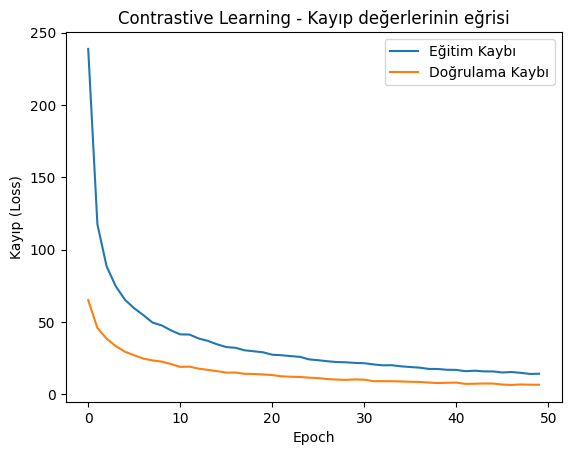

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Contrastive Learning - Kayıp değerlerinin eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.show()

In [ ]:
# Sınıflandırma için model oluşturma (base_network + softmax classifier)
for layer in base_network.layers:
    layer.trainable = False

# Sınıflandırma modeli tanımı
class_input = layers.Input(shape=(224, 224, 3), name="class_input_image")
features = base_network(class_input)
# Üstüne 2 sınıflı bir tam bağlı katman ekleme
classification_output = layers.Dense(2, activation='softmax', name="class_output")(features)
classification_model = Model(class_input, classification_output, name="ClassificationModel")

classification_model.summary()

# Modeli compile etme
classification_model.compile(loss='sparse_categorical_crossentropy',
                             optimizer=tf.keras.optimizers.Adam(0.0005),
                             metrics=['accuracy'])

# Eğitim verisi
train_images = []
train_labels = []
for img_path in list(train_benign) + list(train_malig):
    img_arr = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img_arr)
    img_arr = augmentation_gen.random_transform(img_arr)  # eğitim için augmentation
    img_arr = preprocess_input(img_arr)
    train_images.append(img_arr)
    # Etiket: benign->0, malignant->1
    label = 0 if "benign" in img_path else 1
    train_labels.append(label)
train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels, dtype='int')

# doğrulama
val_images = []
val_labels = []
for img_path in list(val_benign) + list(val_malig):
    img_arr = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img_arr)
    #normalize
    img_arr = preprocess_input(img_arr)
    val_images.append(img_arr)
    label = 0 if "benign" in img_path else 1
    val_labels.append(label)
val_images = np.array(val_images, dtype='float32')
val_labels = np.array(val_labels, dtype='int')

# Sınıflandırma modelini eğitme
clf_history = classification_model.fit(train_images, train_labels,
                                       validation_data=(val_images, val_labels),
                                       epochs=20, batch_size=32, callbacks=[early_stop])

Model: "ClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ class_input_image (InputLayer)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingNetwork (Functional)   │ (None, 256)            │    24,112,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_output (Dense)            │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 514 (2.01 KB)

 Non-trainable params: 24,112,256 (91.98 MB)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.5487 - loss: 0.6955 - val_accuracy: 0.6938 - val_loss: 0.6450
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5907 - loss: 0.6695 - val_accuracy: 0.7312 - val_loss: 0.6275
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6241 - loss: 0.6584 - val_accuracy: 0.7437 - val_loss: 0.6114
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6661 - loss: 0.6214 - val_accuracy: 0.7688 - val_loss: 0.5982
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7195 - loss: 0.5983 - val_accuracy: 0.7750 - val_loss: 0.5859
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7159 - loss: 0.5916 - val_accuracy: 0.7750 - val_loss: 0.5750
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7166 - loss: 0.5833 - val_accuracy: 0.7937 - val_loss: 0.5645
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7564 - loss: 0.5562 - val_accuracy: 0.8188 -

In [ ]:
# Test verisini yükleyeleme
test_images = []
test_labels = []
for img_path in list(test_benign_paths) + list(test_malig_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    test_images.append(img_arr)
    label = 0 if "benign" in img_path else 1
    test_labels.append(label)
test_images = np.array(test_images, dtype='float32')
test_labels = np.array(test_labels, dtype='int')

# Model tahminleri
pred_probs = classification_model.predict(test_images)
# İkinci kolon malignant olasiligi
malig_probs = pred_probs[:, 1]
pred_classes = np.argmax(pred_probs, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
acc = accuracy_score(test_labels, pred_classes)
f1 = f1_score(test_labels, pred_classes, average='binary')
cm = confusion_matrix(test_labels, pred_classes)
fpr, tpr, thresholds = roc_curve(test_labels, malig_probs)
roc_auc = auc(fpr, tpr)

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")
print(f"Test ROC-AUC: {roc_auc:.3f}")
print("Confusion Matrix (TN, FP, FN, TP):")
print(cm)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 822ms/step
Test Accuracy: 84.58%
Test F1-Score: 0.828
Test ROC-AUC: 0.916
Confusion Matrix (TN, FP, FN, TP):
[[114   6]
 [ 31  89]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-9-bd5961b4e4b1>:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


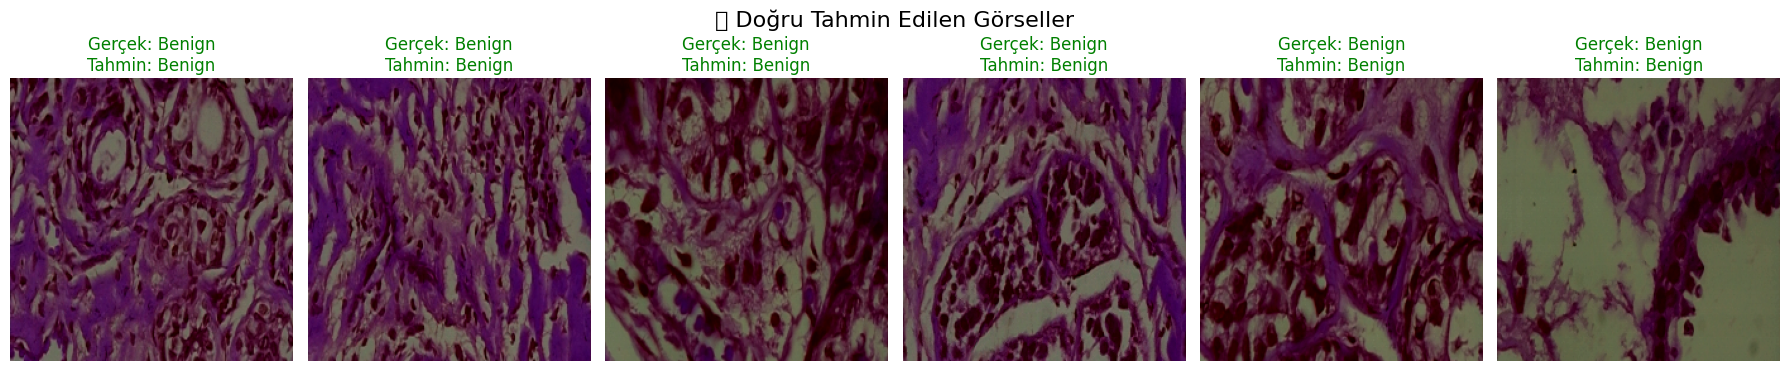

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tahminler
pred_probs = classification_model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

# Doğru tahmin edilen örneklerin indeksleri
correct_indices = np.where(pred_classes == test_labels)[0][:6]

# Görselleri çizdir
plt.figure(figsize=(18, 4))
for i, idx in enumerate(correct_indices):
    img = test_images[idx]
    true_label = 'Benign' if test_labels[idx] == 0 else 'Malignant'
    pred_label = 'Benign' if pred_classes[idx] == 0 else 'Malignant'

    plt.subplot(1, 6, i + 1)
    plt.imshow((img / 255.0).astype(np.float32))
    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color="green")
    plt.axis("off")

plt.suptitle("✅ Doğru Tahmin Edilen Görseller", fontsize=16)
plt.tight_layout()
plt.show()


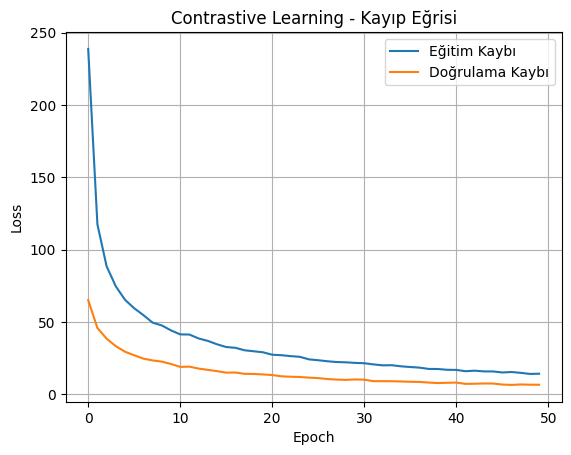

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Contrastive Learning - Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


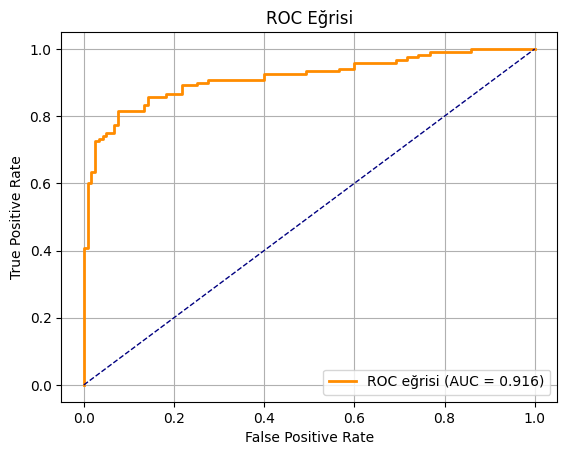

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, malig_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.grid()
plt.show()


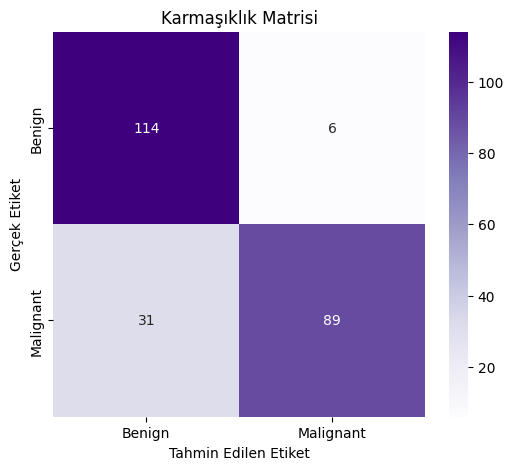

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karmaşıklık Matrisi')
plt.show()


In [ ]:
#Gelişmiş Veri Artırma
from tensorflow.keras.preprocessing.image import ImageDataGenerator

enhanced_augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
#Fine-Tuned Embedding Ağı Tanımı
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model

def create_finetuned_base_network(input_shape=(224, 224, 3)):
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Son 10 katmanı eğitilebilir yap
    for layer in base_cnn.layers[:-10]:
        layer.trainable = False
    for layer in base_cnn.layers[-10:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = base_cnn(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation=None)(x)
    x = layers.Dropout(0.5)(x)
    outputs = x
    return Model(inputs, outputs, name="FinetunedEmbeddingNetwork")


In [ ]:
#Fine-Tuned Siamese Model Tanımı
input_a = layers.Input(shape=(224, 224, 3))
input_b = layers.Input(shape=(224, 224, 3))

finetuned_base_network = create_finetuned_base_network()

embed_a = finetuned_base_network(input_a)
embed_b = finetuned_base_network(input_b)

def euclidean_distance(vects):
    x, y = vects
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

distance = layers.Lambda(euclidean_distance)([embed_a, embed_b])
siamese_model = Model([input_a, input_b], distance)


In [ ]:
#Sınıflayıcı Modelin Oluşturulması
class_input = layers.Input(shape=(224, 224, 3))
features = finetuned_base_network(class_input)
output = layers.Dense(2, activation='softmax')(features)
classifier_model = Model(class_input, output)


In [ ]:
#derleme
classifier_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os

# Tüm eğitim görsellerini oku (benign = 0, malignant = 1)
train_images = []
train_labels = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = f"/content/drive/MyDrive/breast_cancer_project/data/train/{cls}"
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = enhanced_augmentation.random_transform(img)
        img = preprocess_input(img)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels, dtype='int')


In [ ]:
val_images = []
val_labels = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = f"/content/drive/MyDrive/breast_cancer_project/data/test/{cls}"
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        val_images.append(img)
        val_labels.append(label)

val_images = np.array(val_images, dtype='float32')
val_labels = np.array(val_labels, dtype='int')


In [ ]:
classifier_model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_images, val_labels)
)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 449ms/step - accuracy: 0.7754 - loss: 0.5983 - val_accuracy: 0.8727 - val_loss: 0.3890
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9394 - loss: 0.1508 - val_accuracy: 0.9273 - val_loss: 0.3748
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9808 - loss: 0.0498 - val_accuracy: 0.9045 - val_loss: 0.4415
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9889 - loss: 0.0351 - val_accuracy: 0.9318 - val_loss: 0.3981
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9934 - loss: 0.0136 - val_accuracy: 0.9091 - val_loss: 0.4274
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy: 0.9205 - val_loss: 0.4341
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9989 - loss: 0.0087 - val_accuracy: 0.9318 - val_loss: 0.4237
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9136 -

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Tahminleri al
pred_probs = classifier_model.predict(val_images)
pred_classes = np.argmax(pred_probs, axis=1)
malig_probs = pred_probs[:, 1]

# Metikler
acc = accuracy_score(val_labels, pred_classes)
f1 = f1_score(val_labels, pred_classes)
roc_auc = roc_auc_score(val_labels, malig_probs)
cm = confusion_matrix(val_labels, pred_classes)

print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print("Confusion Matrix:")
print(cm)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step
Accuracy: 0.930
F1 Score: 0.925
ROC AUC: 0.970
Confusion Matrix:
[[218   2]
 [ 29 191]]


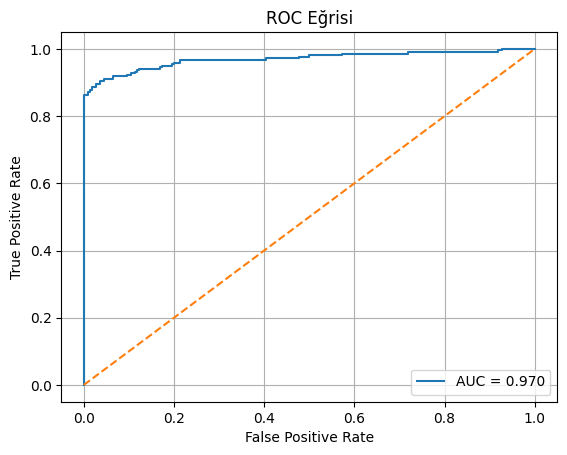

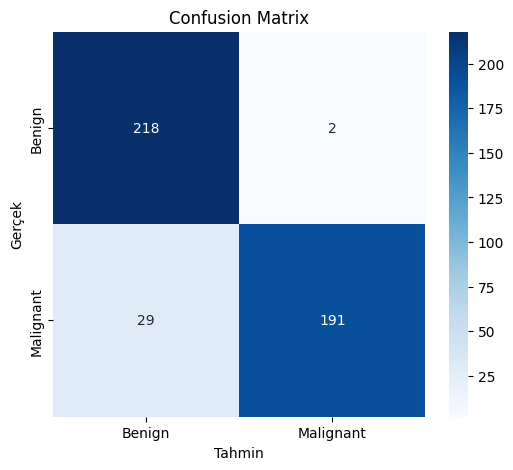

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(val_labels, malig_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix Görseli
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


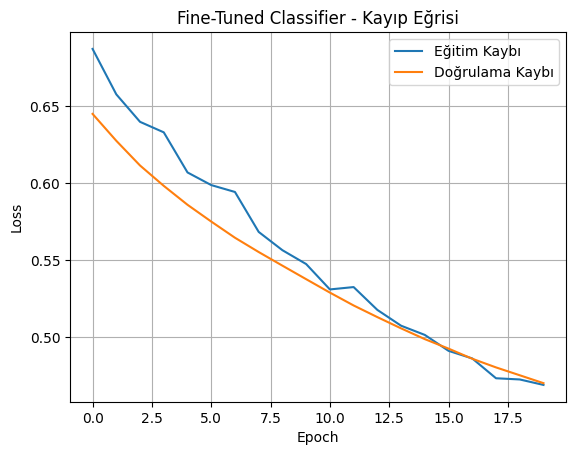

In [ ]:
import matplotlib.pyplot as plt

# Classifier eğitimi sırasında elde edilen history objesi varsa:
plt.plot(clf_history.history['loss'], label='Eğitim Kaybı')
plt.plot(clf_history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Fine-Tuned Classifier - Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

<ipython-input-26-270a35234376>:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


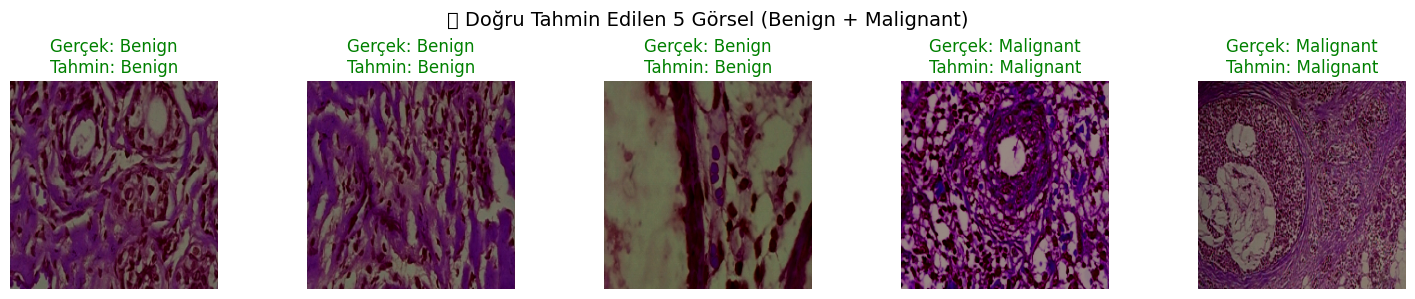

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Doğru tahmin edilen benign ve malignant görsellerin indekslerini al
benign_correct = np.where((val_labels == 0) & (pred_classes == 0))[0][:3]
malig_correct = np.where((val_labels == 1) & (pred_classes == 1))[0][:2]

# İkisini birleştir
correct_indices = np.concatenate([benign_correct, malig_correct])

# Görselleri çizdir
plt.figure(figsize=(15, 3))
for i, idx in enumerate(correct_indices):
    img = val_images[idx]
    true_label = 'Benign' if val_labels[idx] == 0 else 'Malignant'
    pred_label = 'Benign' if pred_classes[idx] == 0 else 'Malignant'

    plt.subplot(1, len(correct_indices), i + 1)
    plt.imshow((img / 255.0).astype(np.float32))
    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color="green")
    plt.axis("off")

plt.suptitle("✅ Doğru Tahmin Edilen 5 Görsel (Benign + Malignant)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
!ls /content/drive/MyDrive/*.h5


In [ ]:
# Google Drive’a kaydetmek için
classifier_model.save('/content/drive/MyDrive/fine_tuned_model_v1.keras')


In [ ]:
!ls -l /content/drive/MyDrive | grep fine_tuned


drwx------ 2 root root      4096 May 15 21:38 fine_tuned_cancer_classifier.h5
-rw------- 1 root root 137054942 May 15 21:41 fine_tuned_model_v1.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

classifier_model = load_model('/content/drive/MyDrive/fine_tuned_model_v1.keras')

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import numpy as np

train_images = []
train_labels = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = "/content/drive/MyDrive/breast_cancer_project/data/train/" + cls
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels, dtype='int')

In [ ]:
val_images = []
val_labels = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = "/content/drive/MyDrive/breast_cancer_project/data/test/" + cls
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        val_images.append(img)
        val_labels.append(label)

val_images = np.array(val_images, dtype='float32')
val_labels = np.array(val_labels, dtype='int')

In [ ]:
classifier_model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 508ms/step - accuracy: 0.9577 - loss: 0.1144 - val_accuracy: 0.9523 - val_loss: 0.2598
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9884 - loss: 0.0382 - val_accuracy: 0.9477 - val_loss: 0.2186
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.9386 - val_loss: 0.2434
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9962 - loss: 0.0062 - val_accuracy: 0.9636 - val_loss: 0.2666
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9984 - loss: 0.0032 - val_accuracy: 0.9500 - val_loss: 0.2609
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9523 - val_loss: 0.3643
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9682 - val_loss: 0.2986
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9614 -

In [ ]:
if not os.path.exists(folder):
    print(f"Klasör bulunamadı: {folder}")
elif len(os.listdir(folder)) == 0:
    print(f"Klasör boş: {folder}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


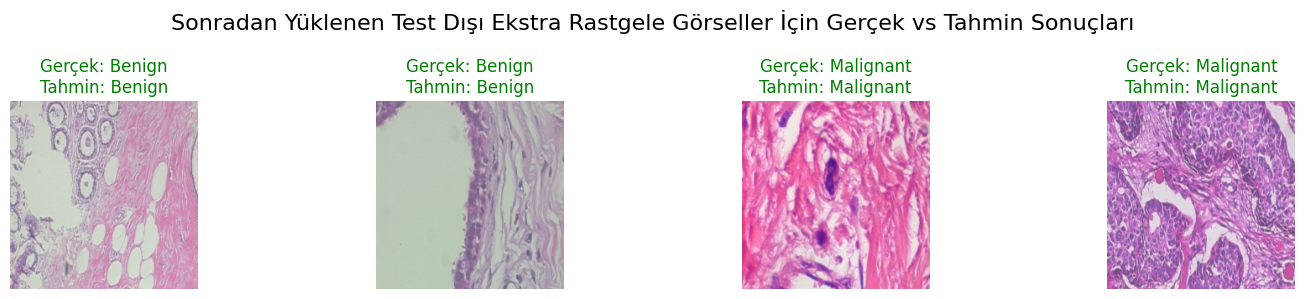

✅ 4 tanesini doğru bildi.
❌ 0 tanesi yanlış tahmin edildi.
📊 Doğruluk oranı: %100.00


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os

# Tahmin klasörü
base_dir = "/content/drive/MyDrive/breast_cancer_project/tahmin"

true_labels = []
pred_labels = []
image_paths = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = os.path.join(base_dir, cls)
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            path = os.path.join(folder, filename)
            image_paths.append(path)
            true_labels.append(label)

            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            prediction = classifier_model.predict(img_array)
            pred_class = np.argmax(prediction)
            pred_labels.append(pred_class)

# Görsel olarak gösterim
plt.figure(figsize=(15, 3))
for i, path in enumerate(image_paths):
    true_cls = "Benign" if true_labels[i] == 0 else "Malignant"
    pred_cls = "Benign" if pred_labels[i] == 0 else "Malignant"
    color = "green" if true_labels[i] == pred_labels[i] else "red"

    plt.subplot(1, len(image_paths), i + 1)
    plt.imshow(load_img(path))
    plt.title(f"Gerçek: {true_cls}\nTahmin: {pred_cls}", color=color)
    plt.axis("off")

plt.suptitle("Sonradan Yüklenen Test Dışı Ekstra Rastgele Görseller İçin Gerçek vs Tahmin Sonuçları", fontsize=16)
plt.tight_layout()
plt.show()

# 📊 Başarı değerlendirmesi
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
dogru = np.sum(true_labels == pred_labels)
toplam = len(true_labels)
oran = dogru / toplam * 100

print(f"✅ {dogru} tanesini doğru bildi.")
print(f"❌ {toplam - dogru} tanesi yanlış tahmin edildi.")
print(f"📊 Doğruluk oranı: %{oran:.2f}")

In [ ]:
import os

print("Mevcut klasörler:")
print(os.listdir("/content/drive/MyDrive/breast_cancer_project"))


Mevcut klasörler:
['README.md', 'outputs', 'notebooks', 'models', ' data yeni', 'data 1', 'data 2 ezberleyen icin kullandim', 'data deneme 4 ve 5 icin', 'data deneme 7 icin', 'data deneme 8 glb', 'data 100x400x200x40x', 'data', 'tahmin']


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


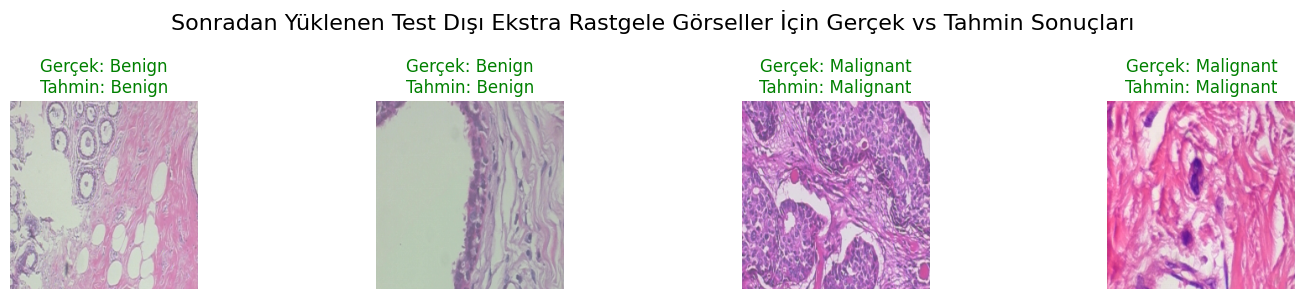

✅ 4 tanesini doğru bildi.
❌ 0 tanesi yanlış tahmin edildi.
📊 Doğruluk oranı: %100.00


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os

# Tahmin klasörü
base_dir = "/content/drive/MyDrive/breast_cancer_project/tahmin"

true_labels = []
pred_labels = []
image_paths = []

for cls, label in zip(['benign', 'malignant'], [0, 1]):
    folder = os.path.join(base_dir, cls)
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            path = os.path.join(folder, filename)
            image_paths.append(path)
            true_labels.append(label)

            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            prediction = classifier_model.predict(img_array)
            pred_class = np.argmax(prediction)
            pred_labels.append(pred_class)

# Görsel olarak gösterim
plt.figure(figsize=(15, 3))
for i, path in enumerate(image_paths):
    true_cls = "Benign" if true_labels[i] == 0 else "Malignant"
    pred_cls = "Benign" if pred_labels[i] == 0 else "Malignant"
    color = "green" if true_labels[i] == pred_labels[i] else "red"

    plt.subplot(1, len(image_paths), i + 1)
    plt.imshow(load_img(path))
    plt.title(f"Gerçek: {true_cls}\nTahmin: {pred_cls}", color=color)
    plt.axis("off")

plt.suptitle("Sonradan Yüklenen Test Dışı Ekstra Rastgele Görseller İçin Gerçek vs Tahmin Sonuçları", fontsize=16)
plt.tight_layout()
plt.show()

# 📊 Başarı değerlendirmesi
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
dogru = np.sum(true_labels == pred_labels)
toplam = len(true_labels)
oran = dogru / toplam * 100

print(f"✅ {dogru} tanesini doğru bildi.")
print(f"❌ {toplam - dogru} tanesi yanlış tahmin edildi.")
print(f"📊 Doğruluk oranı: %{oran:.2f}")